In [97]:
import torch_geometric
import torch
from torch_geometric.nn.pool import knn_graph, knn
import numpy as np
import swyft

import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

import numpy as np
import torch
from torch import nn
import torch
import time
#import unet

import swyft
import pylab as plt
import scipy.stats.distributions as dist
from astropy.visualization import make_lupton_rgb

import pylab as plt

In [98]:
def padding(x, n_full, dim = 0):
    """Pads a tensor in the first dimension"""
    size = list(x.shape)
    n = size[dim]
    size[dim] = n_full
    size = tuple(size)
    #size = (n_full, *x.shape[1:])
    if isinstance(x, torch.Tensor):
        z = torch.zeros(*size, dtype = x.dtype, device = x.device)
    else:
        z = np.zeros(size, dtype = x.dtype)
    if dim == 0:
        z[:n] = x
    elif dim == 1:
        z[:,:n] = x
    else:
        crash
    return z, n

In [130]:
def batch(points, edge_index, nums):
    nums = torch.tensor(nums)
    ptr = torch.cat([torch.zeros(1).long().to(nums.device), torch.cumsum(nums, 0)])

    points = torch.tensor(points)
    points = torch.cat([p[:n] for p, n in zip(points, nums)])
    
    edge_index = torch.tensor(edge_index)
    edge_index = torch.cat([e[:, :n]+p for e, n, p in zip(edge_index, nums, ptr[:-1])], 1)

    return points2, edge_index2, ptr

In [131]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='mean')  # "Add" aggregation (Step 5).
        self.lin = torch.nn.Sequential(
            torch.nn.Linear(in_channels, 256),
            torch.nn.ReLU(),
            torch.nn.LazyLinear(out_channels)
        )
        self.bias = Parameter(torch.Tensor(out_channels))

#        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        #edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        #x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)

        # Step 6: Apply a final bias vector.
        out += self.bias

        return out

    def message(self, norm, x_j, x_i):
        # x_j has shape [E, out_channels]
        m_j = x_j[:,:1]
        r_ji = x_j[:,1:] - x_i[:,1:]
        d = torch.norm(r_ji, dim = 1)
        return m_j

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [153]:
class Simulator(swyft.Simulator):
    def __init__(self, bounds = None, Npix = 64, sigma = 0.1):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.theta_sampler = swyft.RectBoundSampler([dist.uniform(4., 0.1)])
        self.bounds = bounds
        self.Npix = Npix
        self.powersampler = swyft.utils.PowerSpectrumSampler(Npix)
        self.target = self.get_target()
        
    def sample_delta(self, theta):
        if self.bounds is not None:
            i = np.random.randint(len(self.bounds))
            return torch.tensor(self.bounds[i])
        else:
            return self.powersampler.sample(lambda k: 1e6*3*(k/0.5)**-theta[0])

    def get_points(self, mu):
        n = self.Npix
        x = torch.linspace(-1, 1, n)
        dx = x[1] - x[0]
        X, Y = torch.meshgrid((x, x), indexing = 'xy')
        idx = torch.multinomial(mu.flatten(), 1000)
        points = torch.stack([X.flatten()[idx], Y.flatten()[idx]], dim = 1)
        points = points + torch.randn(points.shape)*dx
        return padding(points, 1000)

    def get_target(self):
        n = self.Npix
        x = torch.linspace(-1, 1, n)
        X, Y = torch.meshgrid((x, x), indexing = 'xy')
        target = torch.stack([X.flatten(), Y.flatten()], dim = 1)
        return target

    def get_knn(self, points):
        edge_index = knn(torch.tensor(points), self.target, 5).numpy()
        #print(edge_index.shape)
        return padding(edge_index, self.Npix**2*5, dim = 1)

    #def get_knn(self, points):
    #    edge_index = knn_graph(torch.tensor(points), 5).numpy()
    #    #print(edge_index.shape)
    #    return padding(edge_index, 5000, dim = 1)
                
    def build(self, graph):
        theta = graph.node("theta", self.theta_sampler)
        delta = graph.node("delta", self.sample_delta, theta)
        rho = graph.node("rho", lambda delta: torch.exp(delta/3), delta)
        points, n = graph.node(["points", "n"], self.get_points, rho)
        edge_index, _ = graph.node(["edge_index", "n2"], lambda points, n: self.get_knn(points[:n]), points, n)


/tmp/ipykernel_3623521/5299171.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = knn(torch.tensor(points), self.target, 5).numpy()


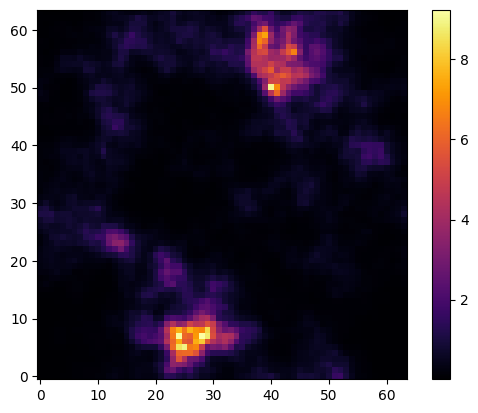

In [155]:
sim = Simulator()
sample = sim.sample()
rho = sample['rho']
plt.imshow(rho, cmap = 'inferno', origin = 'lower')
plt.colorbar()
#print(sample['edge_index'].shape)

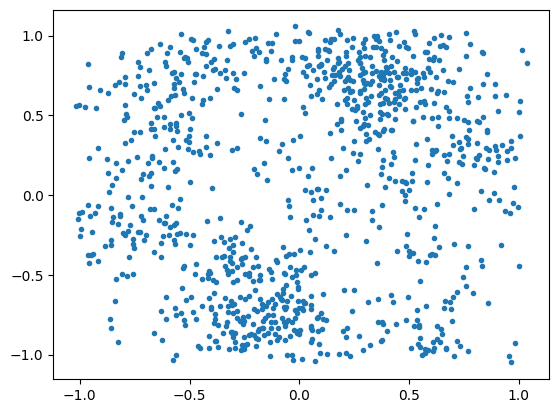

In [156]:
points = sample['points']
plt.scatter(points[:,0], points[:,1], marker='.')

In [157]:
sim = Simulator()
samples = sim.sample(1_00)


  0%|                                                   | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_3623521/5299171.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = knn(torch.tensor(points), self.target, 5).numpy()

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 276.22it/s]


In [165]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 1, varnames = 'd')
        self.g = GCNConv(3, 1)

    def forward(self, A, B):
        points = A['points']
        edge_index = A['edge_index']
        nums = A['n']
        print(edge_index.shape, points.shape, nums.shape)

        x, ei, ptr = batch(points, edge_index, nums)
        print(x.shape, ei.shape)
        out = self.g(x, ei)
        print(out.shape); qwerty
        out = torch_geometric.utils.segment(out, ptr, reduce = 'max')
        z = B['delta'][:,0,0].unsqueeze(-1)
        logratios = self.logratios(out, z)
        return logratios

In [168]:
trainer = swyft.SwyftTrainer(accelerator = 'cpu', devices=1, max_epochs = 10, precision = 64)
dm = swyft.SwyftDataModule(samples, fractions = [0.8, 0.2, 0.0], num_workers = 0, batch_size = 15)
network = Network()
trainer.fit(network, dm)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 17.4 K
1 | g         | GCNConv                | 1.0 K 
-----------------------------------------------------
18.4 K    Trainable params
0         Non-trainable params
18.4 K    Total params
0.147     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|                       | 0/2 [00:00<?, ?it/s]torch.Size([15, 2, 20480]) torch.Size([15, 1000, 2]) torch.Size([15])
torch.Size([15000, 2]) torch.Size([2, 15000])
torch.Size([15000, 1])


/tmp/ipykernel_3623521/3157294189.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nums = torch.tensor(nums)
/tmp/ipykernel_3623521/3157294189.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points = torch.tensor(points)
/tmp/ipykernel_3623521/3157294189.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index)


NameError: name 'qwerty' is not defined